In [1]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
# ukuran gambar
img_width  = 136
img_height = 102

# path folder dataset
dataset_path = './flower_images/'

# ambil nama-nama kelas dari nama folder
classes = os.listdir(dataset_path)

print("Classes:", classes)

# list untuk menampung data dan label
x = []
y = []

counter = 0

Classes: ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']


In [3]:
# import gambar ke dalam x dan label ke dalam y

for class_index, class_name in enumerate(classes):
    class_folder = os.path.join(dataset_path, class_name)

    for img_name in os.listdir(class_folder):
        path = os.path.join(class_folder, img_name)
        
        # load gambar dan ubah ukurannya
        # (target_size = (height, width))
        img = tf.keras.preprocessing.image.load_img(
            path,
            target_size=(img_height, img_width)
        )
        
        # ubah gambar jadi array (H, W, 3)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        
        # masukkan ke list x
        x.append(img_array)
        
        # label = index kelas (0,1,2,3,4)
        y.append(class_index)
    counter += 1

print("Total images:", len(x))
print("Total labels:", len(y))

Total images: 5000
Total labels: 5000


In [4]:
# ubah list jadi numpy array
x = np.array(x, dtype='float32')
y = np.array(y)

print("x shape before norm:", x.shape)
print("y shape:", y.shape)

# normalisasi piksel 0–255 -> 0–1
x = x / 255.0

print("x min:", x.min(), "x max:", x.max())

x shape before norm: (5000, 102, 136, 3)
y shape: (5000,)
x min: 0.0 x max: 1.0


In [ ]:
# split pertama: train dan sisa sementara disebut test
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=400
)

# split kedua: dari x_test lagi dibagi jadi val dan test final
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test,
    test_size=0.2,
    random_state=400
)

# pastikan y jadi vector 1D integer (bukan (N,1))
y_train = np.squeeze(y_train)
y_val   = np.squeeze(y_val)
y_test  = np.squeeze(y_test)

print("y_train shape before one-hot:", y_train.shape)

num_classes = 5  # Lily, Lotus, Orchid, Sunflower, Tulip

# ubah ke one-hot
y_train = to_categorical(y_train, num_classes=num_classes)
y_val   = to_categorical(y_val,   num_classes=num_classes)
y_test  = to_categorical(y_test,  num_classes=num_classes)

print("y_train shape after one-hot:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

# ubah label integer -> one-hot
x_train_rn50 = preprocess_input(x_train * 255.0)
x_val_rn50   = preprocess_input(x_val   * 255.0)
x_test_rn50  = preprocess_input(x_test  * 255.0)

print("x_train_rn50:", x_train_rn50.shape)
print("x_val_rn50  :", x_val_rn50.shape)
print("x_test_rn50 :", x_test_rn50.shape)


y_train shape before one-hot: (4000,)
y_train shape after one-hot: (4000, 5)
y_val shape: (800, 5)
y_test shape: (200, 5)
x_train_rn50: (4000, 102, 136, 3)
x_val_rn50  : (800, 102, 136, 3)
x_test_rn50 : (200, 102, 136, 3)


# Resnet50

In [6]:
from tensorflow.keras.applications import ResNet50

base_rn50 = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

# Tahap 1 = feature extractor → semua layer freeze
base_rn50.trainable = False

base_rn50.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 102, 136, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 108, 142, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 51, 68, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 51, 68, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
from tensorflow.keras.applications import ResNet50

base_rn50 = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

# Tahap 1 = feature extractor -> semua layer freeze
base_rn50.trainable = False

base_rn50.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 102, 136, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 108, 142, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 51, 68, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 51, 68, 64)   256         ['conv1_conv[0][0]']      

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

model_rn50 = Sequential([
    base_rn50,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_rn50.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 24,113,541
Trainable params: 525,829
Non-trainable params: 23,587,712
______________________________________

In [9]:
from tensorflow.keras.optimizers import Adam

model_rn50.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [10]:
history_rn50_stage1 = model_rn50.fit(
    x_train_rn50,
    y_train,
    validation_data=(x_val_rn50, y_val),
    batch_size=64,
    epochs=20
)


Epoch 1/20
63/63 [==============================] - 22s 142ms/step - loss: 1.5540 - accuracy: 0.4465 - val_loss: 0.7475 - val_accuracy: 0.7475
Epoch 2/20
63/63 [==============================] - 7s 118ms/step - loss: 0.8019 - accuracy: 0.6890 - val_loss: 0.5965 - val_accuracy: 0.7850
Epoch 3/20
63/63 [==============================] - 10s 155ms/step - loss: 0.6538 - accuracy: 0.7535 - val_loss: 0.5428 - val_accuracy: 0.8125
Epoch 4/20
63/63 [==============================] - 8s 134ms/step - loss: 0.5563 - accuracy: 0.8037 - val_loss: 0.4730 - val_accuracy: 0.8400
Epoch 5/20
63/63 [==============================] - 8s 128ms/step - loss: 0.4753 - accuracy: 0.8227 - val_loss: 0.4450 - val_accuracy: 0.8537
Epoch 6/20
63/63 [==============================] - 9s 141ms/step - loss: 0.4238 - accuracy: 0.8447 - val_loss: 0.4190 - val_accuracy: 0.8650
Epoch 7/20
63/63 [==============================] - 9s 138ms/step - loss: 0.3924 - accuracy: 0.8583 - val_loss: 0.3919 - val_accuracy: 0.8800
Epoc

In [11]:
test_loss_rn50_1, test_acc_rn50_1 = model_rn50.evaluate(x_test_rn50, y_test, verbose=0)
print("Test loss (ResNet50 Stage 1):", test_loss_rn50_1)
print("Test acc  (ResNet50 Stage 1):", test_acc_rn50_1)


Test loss (ResNet50 Stage 1): 0.206344336271286
Test acc  (ResNet50 Stage 1): 0.949999988079071


In [12]:
import numpy as np

print("Total layers in base_rn50:", len(base_rn50.layers))

# Freeze semua dulu
for layer in base_rn50.layers:
    layer.trainable = False

# Unfreeze 20 layer terakhir
fine_tune_at = 20
for layer in base_rn50.layers[-fine_tune_at:]:
    layer.trainable = True

# Cek berapa yang trainable
trainable_count = np.sum([layer.trainable for layer in base_rn50.layers])
print("Trainable layers in base_rn50 after fine-tune setup:", trainable_count)


Total layers in base_rn50: 175
Trainable layers in base_rn50 after fine-tune setup: 20


In [13]:
from tensorflow.keras.optimizers import Adam

model_rn50.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
history_rn50_ft = model_rn50.fit(
    x_train_rn50,
    y_train,
    validation_data=(x_val_rn50, y_val),
    batch_size=64,
    epochs=20
)

Epoch 1/20
63/63 [==============================] - 9s 118ms/step - loss: 0.2346 - accuracy: 0.9285 - val_loss: 0.2782 - val_accuracy: 0.9187
Epoch 2/20
63/63 [==============================] - 7s 107ms/step - loss: 0.2242 - accuracy: 0.9283 - val_loss: 0.2824 - val_accuracy: 0.9187
Epoch 3/20
63/63 [==============================] - 5s 82ms/step - loss: 0.2200 - accuracy: 0.9348 - val_loss: 0.2857 - val_accuracy: 0.9112
Epoch 4/20
63/63 [==============================] - 8s 127ms/step - loss: 0.2194 - accuracy: 0.9333 - val_loss: 0.2891 - val_accuracy: 0.9137
Epoch 5/20
63/63 [==============================] - 8s 128ms/step - loss: 0.2081 - accuracy: 0.9355 - val_loss: 0.2893 - val_accuracy: 0.9150
Epoch 6/20
63/63 [==============================] - 5s 87ms/step - loss: 0.1963 - accuracy: 0.9433 - val_loss: 0.2882 - val_accuracy: 0.9150
Epoch 7/20
63/63 [==============================] - 6s 93ms/step - loss: 0.2059 - accuracy: 0.9350 - val_loss: 0.2858 - val_accuracy: 0.9162
Epoch 8/2

In [15]:
test_loss_rn50_2, test_acc_rn50_2 = model_rn50.evaluate(x_test_rn50, y_test, verbose=0)
print("Test loss (ResNet50 fine-tuned):", test_loss_rn50_2)
print("Test acc  (ResNet50 fine-tuned):", test_acc_rn50_2)

Test loss (ResNet50 fine-tuned): 0.2309485822916031
Test acc  (ResNet50 fine-tuned): 0.9300000071525574


In [16]:
from sklearn.metrics import classification_report
import numpy as np

# EVAL-2: Prediksi kelas di test set
y_true = np.argmax(y_test, axis=1)   # dari one-hot ke index kelas

y_pred_prob = model_rn50.predict(x_test_rn50)
y_pred = np.argmax(y_pred_prob, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes)) 

7/7 [==============================] - 1s 25ms/step
Classification Report:

              precision    recall  f1-score   support

       Lilly       0.86      0.97      0.91        37
       Lotus       0.91      0.94      0.93        33
      Orchid       0.95      0.89      0.92        44
   Sunflower       0.97      0.95      0.96        37
       Tulip       0.96      0.92      0.94        49

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



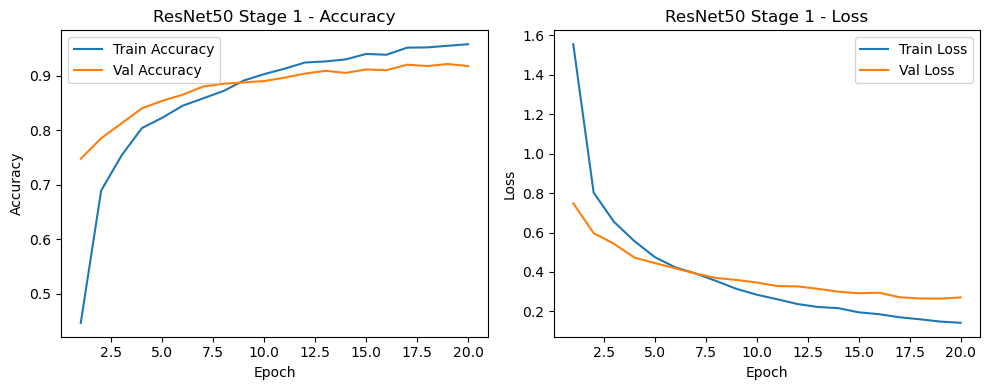

In [17]:
import matplotlib.pyplot as plt

# ambil history
acc      = history_rn50_stage1.history['accuracy']
val_acc  = history_rn50_stage1.history['val_accuracy']
loss     = history_rn50_stage1.history['loss']
val_loss = history_rn50_stage1.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(10, 4))

# Kurva akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet50 Stage 1 - Accuracy')
plt.legend()

# Kurva loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet50 Stage 1 - Loss')
plt.legend()

plt.tight_layout()
plt.show()


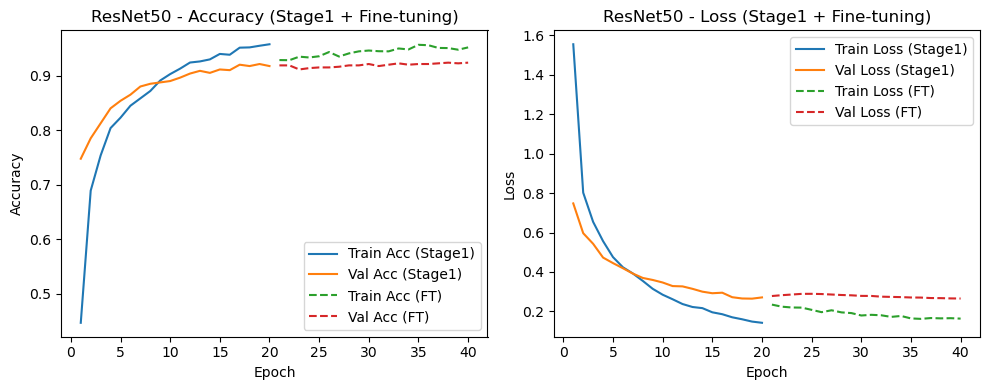

In [18]:
import matplotlib.pyplot as plt

# Stage 1
acc1      = history_rn50_stage1.history['accuracy']
val_acc1  = history_rn50_stage1.history['val_accuracy']
loss1     = history_rn50_stage1.history['loss']
val_loss1 = history_rn50_stage1.history['val_loss']

# Fine-tuning
acc2      = history_rn50_ft.history['accuracy']
val_acc2  = history_rn50_ft.history['val_accuracy']
loss2     = history_rn50_ft.history['loss']
val_loss2 = history_rn50_ft.history['val_loss']

epochs1 = range(1, len(acc1) + 1)
epochs2 = range(len(acc1) + 1, len(acc1) + len(acc2) + 1)

plt.figure(figsize=(10, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs1, acc1, label='Train Acc (Stage1)')
plt.plot(epochs1, val_acc1, label='Val Acc (Stage1)')
plt.plot(epochs2, acc2, '--', label='Train Acc (FT)')
plt.plot(epochs2, val_acc2, '--', label='Val Acc (FT)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet50 - Accuracy (Stage1 + Fine-tuning)')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs1, loss1, label='Train Loss (Stage1)')
plt.plot(epochs1, val_loss1, label='Val Loss (Stage1)')
plt.plot(epochs2, loss2, '--', label='Train Loss (FT)')
plt.plot(epochs2, val_loss2, '--', label='Val Loss (FT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet50 - Loss (Stage1 + Fine-tuning)')
plt.legend()

plt.tight_layout()
plt.show()


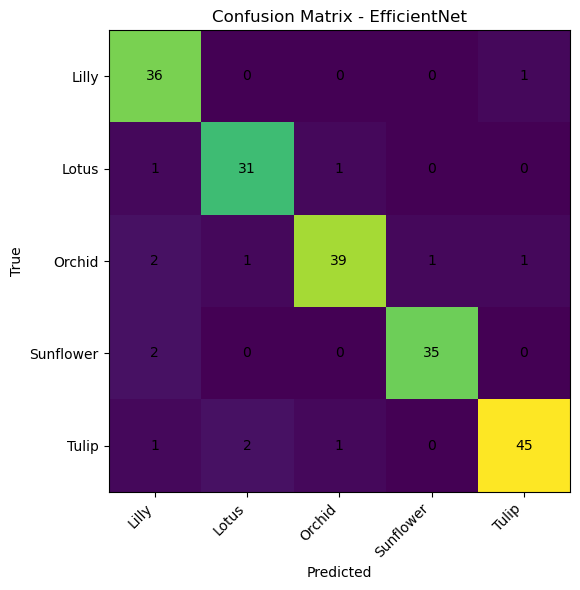

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# EVAL-3: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm)

ax.set_xticks(range(len(classes)))
ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_yticklabels(classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j], ha="center", va="center")

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix - EfficientNet")
plt.tight_layout()
plt.show()


In [20]:
# # 1A. Simpan FULL MODEL dalam format HDF5
# model_rn50.save("resnet50_flower_full.h5")

# # 1B. (opsional tapi sangat disarankan) simpan juga sebagai SavedModel folder
# model_rn50.save("resnet50_flower_savedmodel")